In [1]:
import os
import shutil
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import onnxruntime as ort
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

/home/digvijayyadav48/anaconda3/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/digvijayyadav48/anaconda3/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/digvijayyadav48/anaconda3/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/digvijayyadav48/anaconda3/li

In [2]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
def save_model_to_saved_model(sess, input_tensor, output_tensor):
    from tensorflow.saved_model import simple_save
    save_path = r"/home/digvijayyadav48/package_detector/training-temp/saved_model"
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    simple_save(sess, save_path, {input_tensor.name: input_tensor}, {output_tensor.name: output_tensor})

In [4]:
# # generating mnist.onnx using saved_model
# !python -m tf2onnx.convert \
#         --saved-model /home/digvijayyadav48/package_detector/training-temp/saved_model \
#         --output home/digvijayyadav48/package_detector/tfmodel.onnx \
#         --opset 11

In [5]:
##images /home/digvijayyadav48/Downloads/Packages/JPEGImages/Thu_Dec__3_22_01_38_2020.jpeg
#/home/digvijayyadav48/Downloads/Packages/JPEGImages/1Thu_Dec__3_22_01_22_2020 copy 3.jpeg

img = Image.open('/home/digvijayyadav48/Downloads/Packages/JPEGImages/1Thu_Dec__3_22_01_22_2020 copy 3.jpeg') 
img_data = np.array(img.getdata()).reshape(img.size[1], img.size[0], 3)
img_data = np.expand_dims(img_data.astype(np.uint8), axis=0)
sess_ort = ort.InferenceSession("home/digvijayyadav48/package_detector/tfmodel.onnx")
inputs = sess_ort.get_inputs()[0].name
outputs = ["num_detections", "detection_boxes", "detection_scores", "detection_classes"]
result = sess_ort.run(outputs, {inputs: img_data})
# print("the expected result is \"7\"")
# print("the digit is classified as \"%s\" in ONNXRruntime"%np.argmax(res))

In [6]:
num_detections, detection_boxes, detection_scores, detection_classes = result

In [7]:
num_detections

array([100.], dtype=float32)

In [8]:
detection_scores

array([[0.6451413 , 0.6046027 , 0.21899688, 0.11805251, 0.10190746,
        0.09346572, 0.08872205, 0.07991323, 0.06055018, 0.06013206,
        0.04878491, 0.048287  , 0.04684228, 0.04185799, 0.04180616,
        0.04170823, 0.0366897 , 0.03667387, 0.03317863, 0.02876654,
        0.02865395, 0.02770025, 0.02451995, 0.02328524, 0.02291316,
        0.02204049, 0.02201957, 0.02026474, 0.01813477, 0.01803616,
        0.01783308, 0.01680881, 0.01638311, 0.01537299, 0.01503193,
        0.01481158, 0.01303449, 0.01292837, 0.01273912, 0.01272741,
        0.01261568, 0.01229855, 0.01221174, 0.01185009, 0.01182094,
        0.01177907, 0.01163107, 0.01159513, 0.01137784, 0.01124358,
        0.01100993, 0.01100859, 0.01085031, 0.01083776, 0.01040703,
        0.01038888, 0.01032034, 0.00995025, 0.00969499, 0.00945908,
        0.00933161, 0.00931486, 0.00923565, 0.00922412, 0.0090946 ,
        0.00887468, 0.0088506 , 0.00884226, 0.0088391 , 0.00877047,
        0.00852475, 0.00847131, 0.00845608, 0.00

In [9]:
#@save
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = tf.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = tf.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [10]:
from d2l import tensorflow as d2l
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    w, h = img.size
    bbox[0] = bbox[0]*(w/h)*(450)
    bbox[1] = bbox[1]*(w/h)*(450)
    bbox[2] = bbox[2]*(w/h)*(450)
    bbox[3] = bbox[3]*(w/h)*(450)
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=(bbox[2] - bbox[0]),
                             height=(bbox[3] - bbox[1]), fill=False,
                             edgecolor=color, linewidth=4)

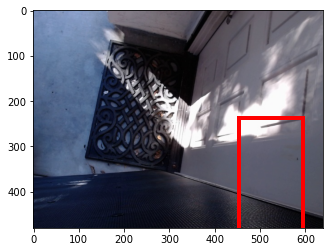

In [11]:
fig = d2l.plt.imshow(img)

batch_size = num_detections.shape[0]
for batch in range(0, batch_size):
    for detection in range(0, int(num_detections[batch])):
        c = detection_classes[batch][detection]
        d = detection_boxes[batch][detection]
    fig.axes.add_patch(bbox_to_rect(d, 'red'))

In [12]:
# image - h/w multiply with bbox